In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
import sympy
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample

### Load precomputed integrals

In [2]:
lagrange_linear_poisson_matrix = dill.load(
    open("../calculations/lagrange_linear_poisson_matrix", "rb")
)
lagrange_linear_poisson_right_values = dill.load(
    open("../calculations/lagrange_linear_poisson_right_values", "rb")
)

### Initialize the domain

In [3]:
t = np.linspace(0, 2 * np.pi, 500, endpoint=False)

points = np.stack((np.cos(t), np.sin(t))).T

seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [4]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.01neo1s")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edges = cndt["edges"]
edge_marker_is_boundary = cndt["edge_markers"]

print(f"Total number of points {points.shape[0]}")

Total number of points 1500


### Visualize the triangulation

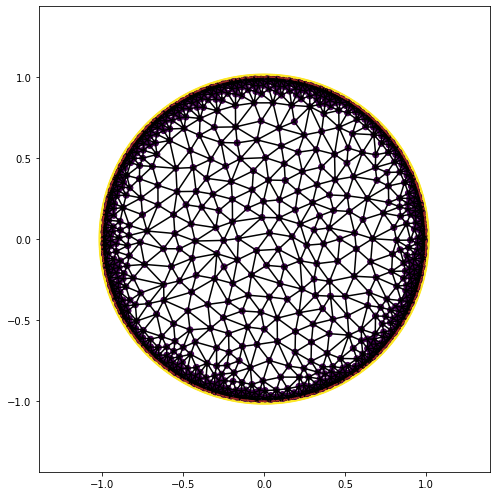

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )

ax.scatter(*points.T, c=vertex_marker_is_boundary)

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [6]:
x, y = sympy.symbols("x y")

In [7]:
F = sympy.Float(1)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

In [8]:
matrix = np.zeros((points.shape[0], points.shape[0]))
b = np.zeros(points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    P_1_x = (-y1 + y3) / delta
    P_1_y = (+x1 - x3) / delta

    P_2_x = (+y1 - y2) / delta
    P_2_y = (-x1 + x2) / delta

    arg = [P_1_x, P_2_x, P_1_y, P_2_y, *right_vals[element]]

    FF = lagrange_linear_poisson_matrix(*arg)
    ff = lagrange_linear_poisson_right_values(*arg)

    for local_point in range(3):
        if vertex_marker_is_boundary[element[local_point]] == True:
            matrix[element[local_point], element[local_point]] = 1
            b[element[local_point]] *= 0
        else:
            for i in range(3):
                matrix[element[local_point], element[i]] += 2 * FF[local_point, i]

            b[element[local_point]] -= 2 * ff[local_point]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2498/2498 [00:00<00:00, 9603.95it/s]


In [9]:
F = np.linalg.solve(matrix, b)

In [10]:
_x_ = points[:, 0]
_y_ = points[:, 1]

In [11]:
U = -(1 - x**2 - y**2) / 4
U = sympy.lambdify((x, y), U)(*points.T)

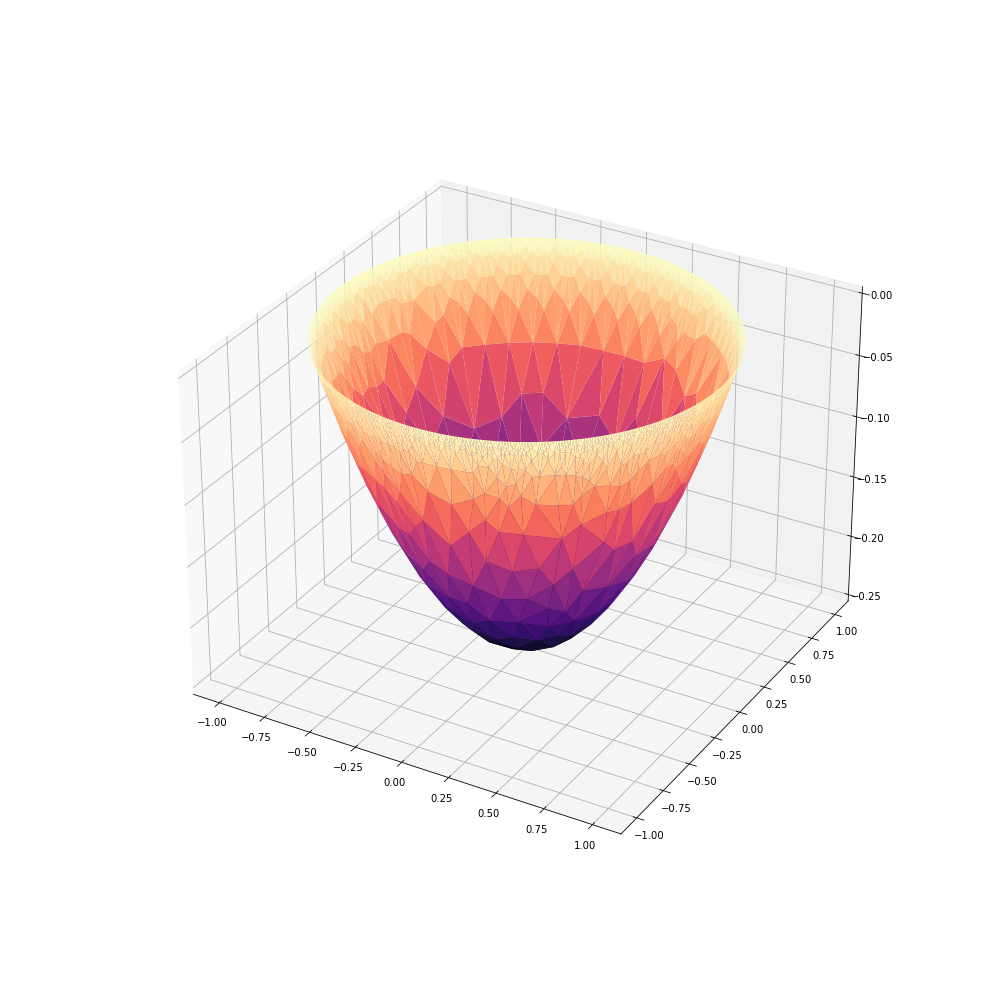

In [12]:
%matplotlib widget
fig = plt.figure(figsize=(14, 14))
ax = plt.axes(projection="3d")
ax.plot_trisurf(_x_, _y_, F, cmap="magma")
plt.show()

### $ \lVert F - \hat{F} \rVert_{\infty}$

In [13]:
abs(U - F).max()

0.0013820240120807625